# Importing Libraries

In [20]:
import os
import pandas as pd
import re
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [14]:
from progressbar import Percentage, ProgressBar, Timer
pbar = ProgressBar(widgets=[Percentage(),Timer()])

In [2]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Importing data

In [4]:
df1 = pd.read_csv('../data/ac_comments_week_ending_2020_03_20.csv')
df2 = pd.read_csv('../data/ac_comments_week_ending_2020_03_27.csv')
df3 = pd.read_csv('../data/ac_comments_week_ending_2020_04_03.csv')
df4 = pd.read_csv('../data/ac_comments_week_ending_2020_04_10.csv')
df5 = pd.read_csv('../data/ac_comments_week_ending_2020_04_17.csv')
df6 = pd.read_csv('../data/ac_comments_week_ending_2020_04_24.csv')
df7 = pd.read_csv('../data/ac_comments_week_ending_2020_05_01.csv')
df8 = pd.read_csv('../data/ac_comments_week_ending_2020_05_08.csv')

In [5]:
frames = [df1,df2,df3,df4,df5,df6,df7,df8]
df_combined = pd.concat(frames)
df_combined['datetime'] = pd.to_datetime(df_combined['created'],unit='s')
df_combined.drop(columns=['Unnamed: 0','created_utc','created'],inplace=True)
df_combined['date'] = pd.DatetimeIndex(df_combined['datetime']).normalize()
df_combined.set_index('datetime',inplace=True)
df_combined

,author,body,id,subreddit,date
datetime,,,,,
2020-03-13 14:00:13,throw_away03082017,Are these preorders?,fkdkuru,AnimalCrossing,2020-03-13
2020-03-13 14:00:21,soundwave145,"Doom,Final fantasy 7,Resident evil 3,Persona 5...",fkdkv0j,AnimalCrossing,2020-03-13
2020-03-13 14:00:22,frescapades,Dang! Just went to pick one up and bc there wa...,fkdkv1w,AnimalCrossing,2020-03-13
2020-03-13 14:00:36,AllForOne21,Start coughing.,fkdkvfu,AnimalCrossing,2020-03-13
2020-03-13 14:00:43,pearlescentsheep,SW-1421-4584-3913 — Probably going with Pearl...,fkdkvnn,AnimalCrossing,2020-03-13
...,...,...,...,...,...
2020-05-08 13:59:48,Srcsqwrn,"Thing is, as long as you're near a cliff, or a...",fpurewr,AnimalCrossing,2020-05-08
2020-05-08 13:59:51,[deleted],[removed],fpurf0u,AnimalCrossing,2020-05-08
2020-05-08 13:59:53,NewEnglandHappyLad,No one cares. This game is dumb.,fpurf45,AnimalCrossing,2020-05-08


In [6]:
len(df_combined)

2125883

# Preprocessing

In [7]:
df_combined = df_combined[(df_combined['author'] != 'AutoModerator') & (df_combined['body'] != '[removed]') & (df_combined['body'] != '[deleted]')]

In [8]:
len(df_combined)

2021741

# Visualization

In [9]:
df_day = df_combined.resample('D').count()
df_day['dayofweek'] = df_day.index.dayofweek
weekend = df_day['dayofweek'].isin(['5','6'])

In [93]:
# df_day

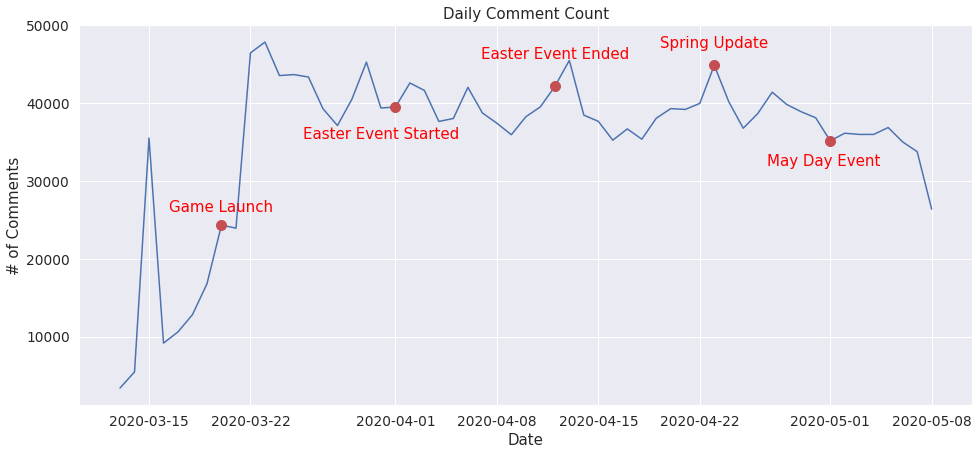

In [61]:
fig, ax = plt.subplots(figsize=(16,7))
sns.set(font_scale=1.25)
sns.lineplot(x=df_day.index,y=df_day['body'])

ax.plot(df_day.index[7], df_day['body'][7], 'ro', markersize=10)
ax.plot(df_day.index[19], df_day['body'][19], 'ro', markersize=10)
ax.plot(df_day.index[30], df_day['body'][30], 'ro', markersize=10)
ax.plot(df_day.index[41], df_day['body'][41], 'ro', markersize=10)
ax.plot(df_day.index[49], df_day['body'][49], 'ro', markersize=10)
ax.set_title('Daily Comment Count')
ax.set_xlabel('Date')
ax.set_ylabel('# of Comments')
ax.text(.1,.51,'Game Launch', transform=ax.transAxes, c='red')
ax.text(.25,.7,'Easter Event Started', transform=ax.transAxes, c='red')
ax.text(.45,.91,'Easter Event Ended', transform=ax.transAxes, c='red')
ax.text(.65,.94,'Spring Update', transform=ax.transAxes, c='red')
ax.text(.77,.63,'May Day Event', transform=ax.transAxes, c='red')
plt.savefig('../img/total_comment_count.png', bbox_inches = "tight")

# Vadar

In [12]:
sid = SentimentIntensityAnalyzer()

In [15]:
scores = []
sentiment = []
for comments in pbar(df_combined['body']):
    sent_score = sid.polarity_scores(str(comments))['compound']
    scores.append(sent_score)
    if sent_score >= 0.05:
        sentiment.append('pos')
    elif sent_score > -0.05 and sent_score < 0.05:
        sentiment.append('neu')
    else:
        sentiment.append('neg')

100%Elapsed Time: 0:09:21                                                      


In [16]:
display(len(scores))
display(len(sentiment))

2021741

2021741

In [17]:
df_combined['sent_score'] = scores
df_combined['sentiment'] = sentiment

/home/tl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/tl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
df_combined

,author,body,id,subreddit,date,sent_score,sentiment
datetime,,,,,,,
2020-03-13 14:00:13,throw_away03082017,Are these preorders?,fkdkuru,AnimalCrossing,2020-03-13,0.0000,neu
2020-03-13 14:00:21,soundwave145,"Doom,Final fantasy 7,Resident evil 3,Persona 5...",fkdkv0j,AnimalCrossing,2020-03-13,0.0772,pos
2020-03-13 14:00:22,frescapades,Dang! Just went to pick one up and bc there wa...,fkdkv1w,AnimalCrossing,2020-03-13,0.2003,pos
2020-03-13 14:00:36,AllForOne21,Start coughing.,fkdkvfu,AnimalCrossing,2020-03-13,0.0000,neu
2020-03-13 14:00:43,pearlescentsheep,SW-1421-4584-3913 — Probably going with Pearl...,fkdkvnn,AnimalCrossing,2020-03-13,0.1007,pos
...,...,...,...,...,...,...,...
2020-05-08 13:59:41,lpaige2723,Label gave my boyfriend a lovely pink Sun hat ...,fpurelz,AnimalCrossing,2020-05-08,0.5859,pos
2020-05-08 13:59:48,Srcsqwrn,"Thing is, as long as you're near a cliff, or a...",fpurewr,AnimalCrossing,2020-05-08,0.4005,pos
2020-05-08 13:59:53,NewEnglandHappyLad,No one cares. This game is dumb.,fpurf45,AnimalCrossing,2020-05-08,-0.3612,neg


In [21]:
filename = 'all_comments_with_sentiment.csv'
path = "../data/"
fullpath = os.path.join(path, filename)
fullpath

'../data/all_comments_with_sentiment.csv'

In [23]:
df_combined.reset_index().to_csv(fullpath)

In [24]:
df_combined_ = df_combined.groupby(['date','sentiment']).agg({'sent_score': 'count'})
df_combined_perc = df_combined_ .groupby(level=0).apply(lambda x: round(100 * x / float(x.sum()),2))

In [25]:
df_sentiment_proportion_by_day = df_combined_perc.reset_index()
df_pos = df_sentiment_proportion_by_day[df_sentiment_proportion_by_day['sentiment'] == 'pos']
df_neu = df_sentiment_proportion_by_day[df_sentiment_proportion_by_day['sentiment'] == 'neu']
df_neg = df_sentiment_proportion_by_day[df_sentiment_proportion_by_day['sentiment'] == 'neg']

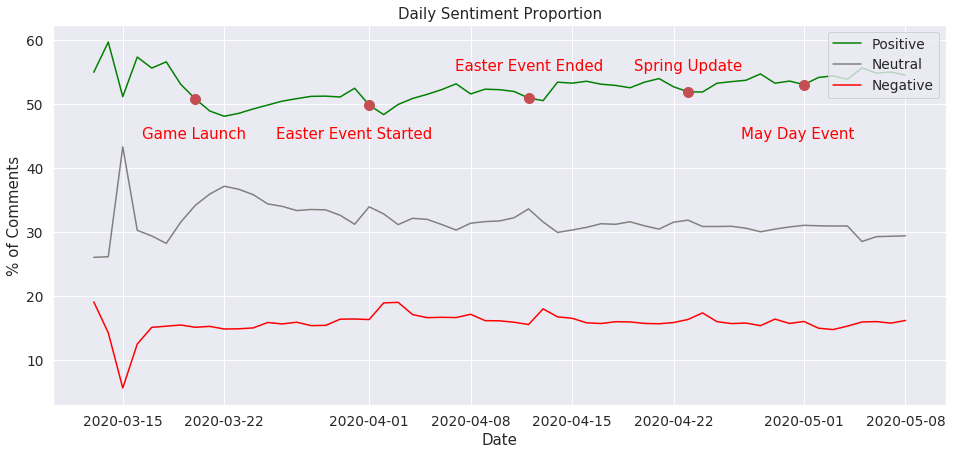

In [63]:
fig, ax = plt.subplots(figsize=(16,7))
sns.set(font_scale=1.25)
sns.lineplot(x=df_pos['date'],y=df_pos['sent_score'],color='green')
sns.lineplot(x=df_neu['date'],y=df_neu['sent_score'],color='gray')
sns.lineplot(x=df_neg['date'],y=df_neg['sent_score'],color='red')
ax.plot(df_pos['date'].iloc[7], df_pos['sent_score'].iloc[7], 'ro', markersize=10)
ax.plot(df_pos['date'].iloc[19], df_pos['sent_score'].iloc[19], 'ro', markersize=10)
ax.plot(df_pos['date'].iloc[30], df_pos['sent_score'].iloc[30], 'ro', markersize=10)
ax.plot(df_pos['date'].iloc[41], df_pos['sent_score'].iloc[41], 'ro', markersize=10)
ax.plot(df_pos['date'].iloc[49], df_pos['sent_score'].iloc[49], 'ro', markersize=10)
ax.set_title('Daily Sentiment Proportion')
ax.set_xlabel('Date')
ax.set_ylabel('% of Comments')
ax.text(.1,.7,'Game Launch', transform=ax.transAxes, c='red')
ax.text(.25,.7,'Easter Event Started', transform=ax.transAxes, c='red')
ax.text(.45,.88,'Easter Event Ended', transform=ax.transAxes, c='red')
ax.text(.65,.88,'Spring Update', transform=ax.transAxes, c='red')
ax.text(.77,.7,'May Day Event', transform=ax.transAxes, c='red')
plt.legend(loc='upper right', labels=['Positive', 'Neutral', 'Negative'])
plt.savefig('../img/senti_prop.png', bbox_inches = "tight")

# What are the most positive, most neutral negative comments?

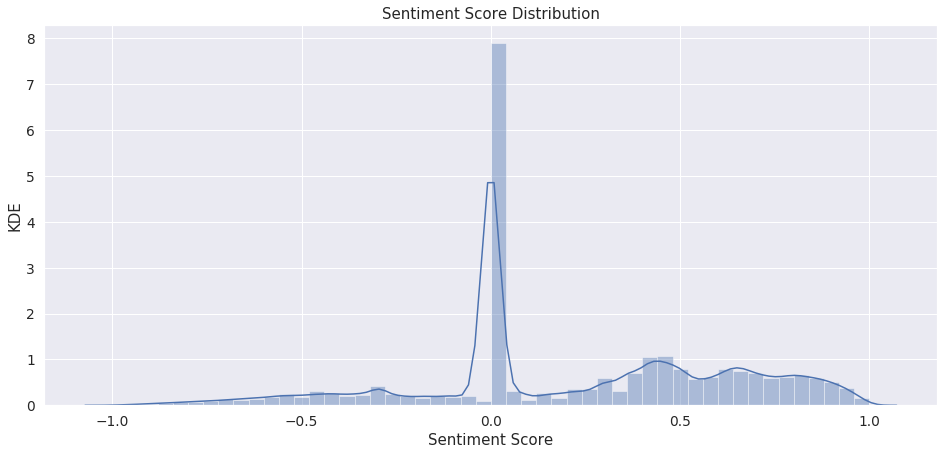

In [79]:
fig, ax = plt.subplots(figsize=(16,7))
sns.set(font_scale=1.25)
sns.distplot(df_combined.reset_index()['sent_score'])
ax.set_title('Sentiment Score Distribution')
ax.set_xlabel('Sentiment Score')
ax.set_ylabel('KDE')
plt.savefig('../img/senti_dist.png', bbox_inches = "tight")

In [168]:
df_combined['sent_score'].describe()

count    2.021741e+06
mean     2.252494e-01
std      4.120894e-01
min     -1.000000e+00
25%      0.000000e+00
50%      1.511000e-01
75%      5.719000e-01
max      1.000000e+00
Name: sent_score, dtype: float64

In [169]:
df_combined['sent_score'].quantile(.95)

0.864

In [170]:
df_combined['sent_score'].quantile(.05)

-0.5096

# wordcloud

In [38]:
stopwords = set(STOPWORDS)

In [51]:
most_negative = df_combined.sort_values('sent_score')['body'][0:10000].values
most_positive = df_combined.sort_values('sent_score',ascending=False)['body'][0:10000].values
most_negative_corpus = " ".join(str(comment) for comment in most_negative)
most_positive_corpus = " ".join(str(comment) for comment in most_positive)

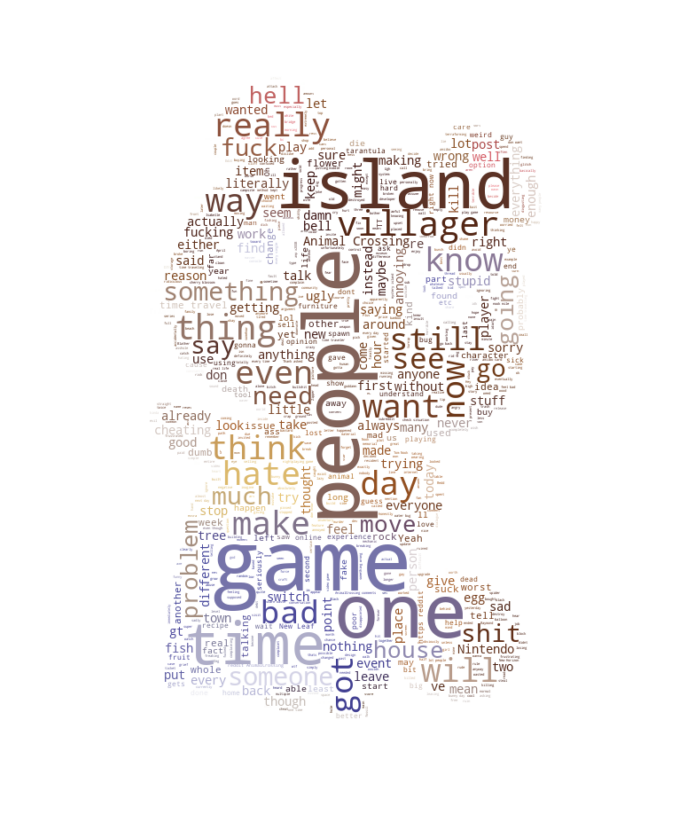

In [54]:
mask = np.array(Image.open("../img/tom_nook.jpg"))
wordcloud_nook_neg = WordCloud(stopwords=stopwords,mode="RGBA", background_color="white", max_words=1000, mask=mask).generate(most_negative_corpus)

image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[15,15])
plt.imshow(wordcloud_nook_neg.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.savefig('../img/wordcloud_most_neg.png', bbox_inches = "tight")

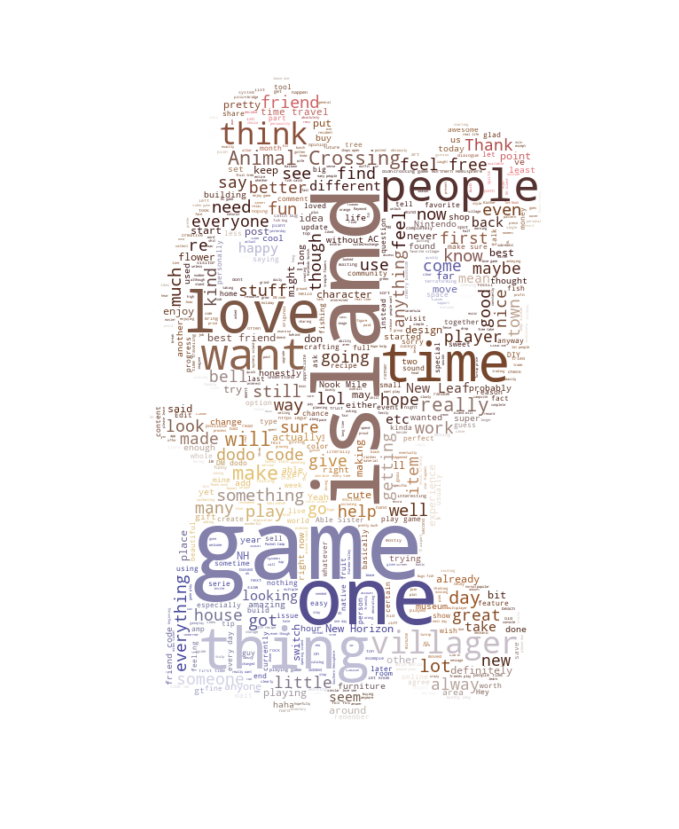

In [55]:
mask = np.array(Image.open("../img/tom_nook.jpg"))
wordcloud_nook_pos = WordCloud(stopwords=stopwords,mode="RGBA", background_color="white", max_words=1000, mask=mask).generate(most_positive_corpus)

image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[15,15])
plt.imshow(wordcloud_nook_pos.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
plt.savefig('../img/wordcloud_most_pos.png', bbox_inches = "tight")